*Exercise 10: Use transfer learning for large image classification:*

In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

- the PlantVillage dataset consists of 54303 healthy and unhealthy leaf images divided into 38 categories by species and disease

In [2]:
# loading the dataset
import tensorflow_datasets as tfds

dataset, info = tfds.load("plant_village", as_supervised=True, with_info=True)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/plant_village/1.0.0.incompleteIGCKDI/plant_village-train.tfrecord


Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.0. Subsequent calls will reuse this data.


In [6]:
dataset_size = info.splits["train"].num_examples
dataset_size # number of training examples

54303

In [7]:
class_names = info.features["label"].names
len(class_names) # 38 classes

38

In [8]:
print(class_names)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry___healthy', 'Cherry___Powdery_mildew', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___healthy', 'Corn___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___

- there is only a `"train"` dataset: no test or validation set, so we need to split the training set
- the TF Datasets project provides an API for this
 - for example, let's take the first 10% of the dataset for testing, the next 15% for validation, and the remaining 75% for training:

In [0]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "plant_village",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

- next we must preprocess the images as the Xception model expects 244 x 244 images
- we will write functions for data augmentation:
 - we use `tf.image.random_crop()` to randomly crop the images and `tf.image.random_flip_left_right()` to randomly flip the images horizontally, and so on

In [0]:
# data augmentation
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

- **let's apply this preprocessing function to all 3 datasets, shuffle the training set, and add batching and prefetching to all the datasets**

In [0]:
from functools import partial

batch_size = 80

# shuffling the training set
train_set = train_set_raw.shuffle(1000).repeat() 

# applying the preprocessing function, batching, and prefetching to all 3 datasets
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

- the Xception model was proposed by François Chollet (author of Keras) in 2016
- Xception merges the ideas of GoogLeNet and ResNet, but replaces the inception modules with a special type of layer called a *depthwise separable convolution layer* 
 - regular convolutional layers use filters that try to simultaneously capture spatial patterns (e.g., an oval) and cross-channel patterns (e.g., mouth + nose + eyes = face), **a separable convolutional layer, however, makes the strong assumption that spatial patterns and cross-channel patterns can be modeled separately**
 - separable convolutional layers use fewer parameters, less memory, and fewer computations than regular convolutional layers, and in general they perform better, so you should consider using them by default
---
- next, let's load an Xception model, pretrained on ImageNet
- we exclude the top of the network by setting `include_top=False`: this excludes the global average pooling layer and the dense output layer
- we then add our own global average pooling layer based on the output of the base model, followed by a dense output layer with one unit per class using the softmax activation function
- finally, we create the Keras `Model`:

In [23]:
base_model = keras.applications.xception.Xception(weights="imagenet", # pretrained on ImageNet
                                                  include_top=False) # excludes the top of the network                 
avg = keras.layers.GlobalAveragePooling2D()(base_model.output) # our own global average pooling layer based on the output of the base model
output = keras.layers.Dense(38, activation="softmax")(avg) # 38 classes
model = keras.models.Model(inputs=base_model.input, outputs=output)

83689472/83683744 [==============================] - 1s 0us/step


In [25]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_act

- as explained in Chapter 11, **it's usually a good idea to freeze the weights of the pretrained layers, at least at the beginning of training**:
 - since our model uses the base model's layers directly, we have to run this loop with `layer.trainable = False`
 - if our model used the `base_model` object itself, we could just set `base_model.trainable = False`

In [0]:
# freezing the weights of the pretrained layers
for layer in base_model.layers:
    layer.trainable = False 

- if your targets are one-hot encoded, use `categorical_crossentropy`
- but if your targets are integers, use `sparse_categorical_crossentropy`
 - this is applicable to our case


In [0]:
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [28]:
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size), # we are using 90, but a batch size of 32 is a good default
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
509/509 [==============================] - 468s 919ms/step - loss: 0.4960 - accuracy: 0.8530 - val_loss: 0.2928 - val_accuracy: 0.9082
Epoch 2/5
509/509 [==============================] - 468s 920ms/step - loss: 0.2521 - accuracy: 0.9227 - val_loss: 0.2594 - val_accuracy: 0.9172
Epoch 3/5
509/509 [==============================] - 468s 919ms/step - loss: 0.2247 - accuracy: 0.9333 - val_loss: 0.2465 - val_accuracy: 0.9244
Epoch 4/5
509/509 [==============================] - 468s 919ms/step - loss: 0.2152 - accuracy: 0.9354 - val_loss: 0.2348 - val_accuracy: 0.9252
Epoch 5/5
509/509 [==============================] - 468s 920ms/step - loss: 0.2050 - accuracy: 0.9390 - val_loss: 0.2287 - val_accuracy: 0.9286


- after training the model for a few epochs, its validation accuracy should reach about 75-80% and stop making much progress
 - this means that the top layers are now pretty well trained, so we are ready to unfreeze all the layers
- **this time we use a much lower learning rate to avoid damaging the pretrained weights**

In [0]:
# unfreezing the weights of the pretrained layers
for layer in base_model.layers:
    layer.trainable = True

- the cell below takes an extremely long time to run

In [0]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, # lower learning rate as to not damage the pretrained weights
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40) # 40 epochs this time

- with that, you can start training amazing image classifiers

*Exercise 11): Go through TensorFlow's [Style Transfer tutorial](https://homl.info/styletuto). It is a fun way to generate art using Deep Learning.*

- *neural style transfer* is an optimization technique used to take two images—a *content* image and a style *reference* image (such as an artwork by a famous painter)—and blend them together so the output image looks like the content image, but “painted” in the style of the style reference images
---
- **TF-Hub: Fast Style Transfer for Arbitrary Styles**

In [42]:
# setup
import functools
import os

from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF Version: ", tf.__version__)
print("TF-Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.test.is_gpu_available())

TF Version:  2.2.0
TF-Hub version:  0.8.0
Eager mode enabled:  True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU available:  True


In [0]:
# @title Define image loading and visualization functions  { display-mode: "form" }

def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image

@functools.lru_cache(maxsize=None)
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""
  # Cache image file locally.
  image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = plt.imread(image_path).astype(np.float32)[np.newaxis, ...]
  if img.max() > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img

def show_n(images, titles=('',)):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w  * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()


2686976/2684586 [==============================] - 0s 0us/step


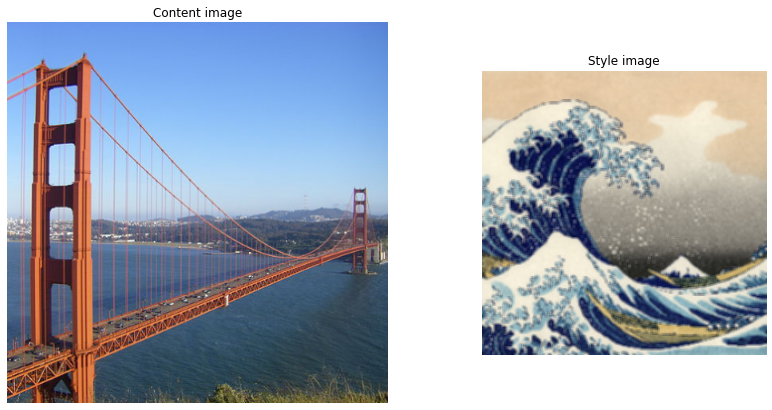

In [46]:
# @title Load example images  { display-mode: "form" }

content_image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Golden_Gate_Bridge_from_Battery_Spencer.jpg/640px-Golden_Gate_Bridge_from_Battery_Spencer.jpg'  # @param {type:"string"}
style_image_url = 'https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg'  # @param {type:"string"}
output_image_size = 384  # @param {type:"integer"}

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the 
# recommended image size for the style image (though, other sizes work as 
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

content_image = load_image(content_image_url, content_img_size)
style_image = load_image(style_image_url, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
show_n([content_image, style_image], ['Content image', 'Style image'])

In [0]:
# Load TF-Hub module.

hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

The signature of this hub module for image stylization is:
```
outputs = hub_module(content_image, style_image)
stylized_image = outputs[0]
```
Where `content_image`, `style_image`, and `stylized_image` are expected to be 4-D Tensors with shapes `[batch_size, image_height, image_width, 3]`.

In the current example we provide only single images and therefore the batch dimension is 1, but one can use the same module to process more images at the same time.

The input and output values of the images should be in the range [0, 1].

The shapes of content and style image don't have to match. Output image shape
is the same as the content image shape.

## Demonstrate image stylization

In [0]:
# Stylize content image with given style image.
# This is pretty fast within a few milliseconds on a GPU.

outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

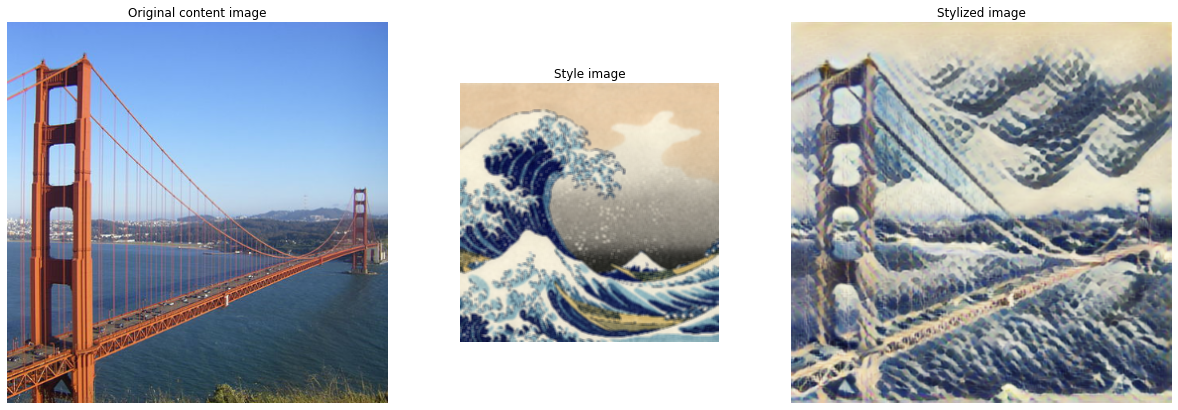

In [50]:
# Visualize input images and the generated stylized image.

show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])

In [0]:
# @title To Run: Load more images { display-mode: "form" }

content_urls = dict(
  sea_turtle='https://upload.wikimedia.org/wikipedia/commons/d/d7/Green_Sea_Turtle_grazing_seagrass.jpg',
  tuebingen='https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg',
  grace_hopper='https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg',
  addison_rae='https://upload.wikimedia.org/wikipedia/commons/3/34/Addison_rae_test_image.jpg'
)
style_urls = dict(
  kanagawa_great_wave='https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg',
  kandinsky_composition_7='https://upload.wikimedia.org/wikipedia/commons/b/b4/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg',
  hubble_pillars_of_creation='https://upload.wikimedia.org/wikipedia/commons/6/68/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg',
  van_gogh_starry_night='https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg',
  turner_nantes='https://upload.wikimedia.org/wikipedia/commons/b/b7/JMW_Turner_-_Nantes_from_the_Ile_Feydeau.jpg',
  munch_scream='https://upload.wikimedia.org/wikipedia/commons/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg',
  picasso_demoiselles_avignon='https://upload.wikimedia.org/wikipedia/en/4/4c/Les_Demoiselles_d%27Avignon.jpg',
  picasso_violin='https://upload.wikimedia.org/wikipedia/en/3/3c/Pablo_Picasso%2C_1911-12%2C_Violon_%28Violin%29%2C_oil_on_canvas%2C_Kr%C3%B6ller-M%C3%BCller_Museum%2C_Otterlo%2C_Netherlands.jpg',
  picasso_bottle_of_rum='https://upload.wikimedia.org/wikipedia/en/7/7f/Pablo_Picasso%2C_1911%2C_Still_Life_with_a_Bottle_of_Rum%2C_oil_on_canvas%2C_61.3_x_50.5_cm%2C_Metropolitan_Museum_of_Art%2C_New_York.jpg',
  fire='https://upload.wikimedia.org/wikipedia/commons/3/36/Large_bonfire.jpg',
  derkovits_woman_head='https://upload.wikimedia.org/wikipedia/commons/0/0d/Derkovits_Gyula_Woman_head_1922.jpg',
  amadeo_style_life='https://upload.wikimedia.org/wikipedia/commons/8/8e/Untitled_%28Still_life%29_%281913%29_-_Amadeo_Souza-Cardoso_%281887-1918%29_%2817385824283%29.jpg',
  derkovtis_talig='https://upload.wikimedia.org/wikipedia/commons/3/37/Derkovits_Gyula_Talig%C3%A1s_1920.jpg',
  amadeo_cardoso='https://upload.wikimedia.org/wikipedia/commons/7/7d/Amadeo_de_Souza-Cardoso%2C_1915_-_Landscape_with_black_figure.jpg',
  anime_filter='https://upload.wikimedia.org/wikipedia/commons/d/dc/Anime_Girl_upright_version.jpg',
  anime_filter2='https://upload.wikimedia.org/wikipedia/commons/d/df/Anime_girl_at_beach.jpg',
  anime_filter3='https://upload.wikimedia.org/wikipedia/commons/6/62/Wikipe-tan_face.jpg'
)

content_image_size = 384
style_image_size = 256
content_images = {k: load_image(v, (content_image_size, content_image_size)) for k, v in content_urls.items()}
style_images = {k: load_image(v, (style_image_size, style_image_size)) for k, v in style_urls.items()}
style_images = {k: tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME') for k, style_image in style_images.items()}

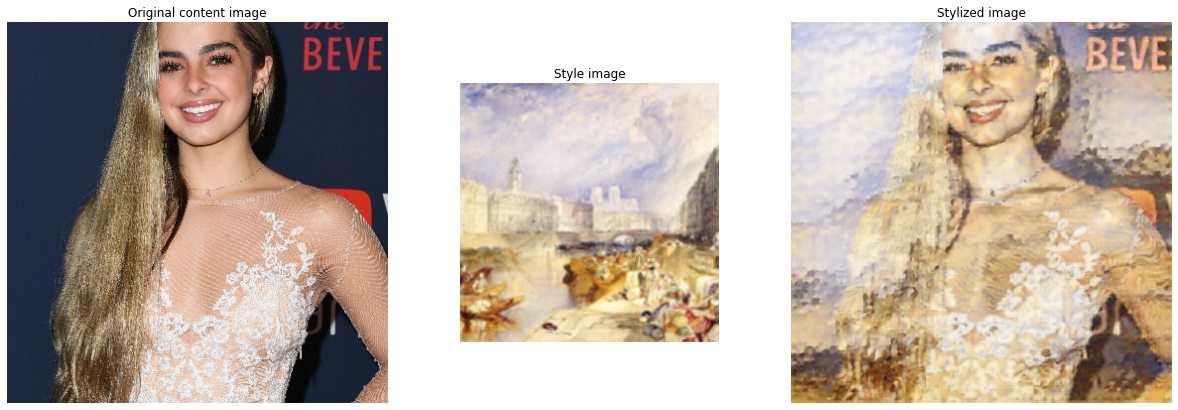

In [92]:
#@title Specify the main content image and the style you want to use.  { display-mode: "form" }

content_name = 'addison_rae'  # @param ['sea_turtle', 'tuebingen', 'grace_hopper', 'addison_rae']
style_name = 'turner_nantes'  # @param ['kanagawa_great_wave', 'kandinsky_composition_7', 'hubble_pillars_of_creation', 'van_gogh_starry_night', 'turner_nantes', 'munch_scream', 'picasso_demoiselles_avignon', 'picasso_violin', 'picasso_bottle_of_rum', 'fire', 'derkovits_woman_head', 'amadeo_style_life', 'derkovtis_talig', 'amadeo_cardoso', 'anime_filter', 'anime_filter2', 'anime_filter3']

stylized_image = hub_module(tf.constant(content_images[content_name]),
                            tf.constant(style_images[style_name]))[0]

show_n([content_images[content_name], style_images[style_name], stylized_image],
       titles=['Original content image', 'Style image', 'Stylized image'])